In [1]:
import os, sys
from tqdm import trange
from IPython.utils import io

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
from simulate import rep_sim

import models
from models import MLP, CNN, ResNet

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

with io.capture_output() as captured:
    pub_show()

GPU available


In [2]:
settings = pd.read_csv("model settings.txt", sep=" ", header=0)

In [3]:
def compute_tau(setting):
    ## Load settings
    (
        model_type,
        nonlinearity,
        gain,
        lr,
        P,
        L,
        n_epochs,
        hidden_layer,
        dx2,
        dy2,
        in_dim,
        out_dim,
        eta_guess,
    ) = settings.loc[setting].to_numpy()
    model_type = getattr(models, model_type)
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

    ## Generate data

    input_dim, output_dim = in_dim, out_dim

    inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
        input_dim
    )
    outputs = np.array(
        [[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]
    ) / np.sqrt(output_dim)
    names = ["A", "B"]
    data = TensorDataset(
        torch.from_numpy(inputs.astype(np.float32)).to(device),
        torch.from_numpy(outputs.astype(np.float32)).to(device),
    )

    encoding = Encoding(dict(zip(names, inputs)))

    train_datasets = [data]
    val_dataset = [data]

    tracked_datasets = val_dataset + train_datasets

    ## Instantiate model
    model = model_type(
        encoding=encoding,
        input_size=inputs.shape[1],
        output_size=outputs.shape[1],
        hidden_dim=P,
        n_hid_layers=L,
        device=device,
        init_std=gain,
        non_linearity=nonlinearity,
    )

    ## Setup compiler

    # Define Loss, Optimizer
    criterion = nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
        "hidden": ActivationTracker(
            model, lambda inputs: model(inputs)[1][hidden_layer]
        ),
        "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
    }

    ## Training run
    with io.capture_output() as captured:
        compiler.training_run(
            train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
        )

    data_hid = compiler.trackers["hidden"].get_trace()
    data_output = compiler.trackers["output"].get_trace()
    mod = 10
    query = f"Epoch % {mod} == 0"
    data_hid = data_hid.copy().query(query)
    data_output = data_output.copy().query(query)

    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    y_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]
    y_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]

    epochs = np.arange(0, len(h_A))

    y_true_A, y_true_B = outputs[0], outputs[1]
    dy2 = np.sum((y_true_B - y_true_A) ** 2)
    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
    y = [y_B[epoch] - y_A[epoch] - (y_true_B - y_true_A) for epoch in epochs]
    y2 = np.array([np.sum((y[epoch]) ** 2) for epoch in epochs])
    w = np.array(
        [y2[epoch] + np.dot(y_true_B - y_true_A, y[epoch]) for epoch in epochs]
    )

    h0, y0, w0, dy = h2[0], y2[0], w[0], dy2
    epochs = epochs * mod

    ## Fit effective learning rates

    def model_accuracy(pars):
        eta_h, eta_y = pars

        fun = lambda h: h

        def der(t, z):
            h, y, w = z
            return [
                -eta_h * w,
                -(eta_y * fun(h) * y + eta_h * w**2 / h),
                0.5 * (eta_y * fun(h) * (-w - y) - eta_h * (w / h) * (3 * w - y + dy)),
            ]

        t_max = len(epochs)

        sol = scipy.integrate.solve_ivp(
            der, [0, t_max], [h0, y0, w0], dense_output=True, rtol=1e-2, atol=1e-5
        )

        t = np.linspace(0, t_max, len(epochs))
        z = sol.sol(t)
        t = t / t_max

        loss = (
            np.sum((h2 - z[0]) ** 2)
            + np.sum((y2 - z[1]) ** 2)
            + np.sum((w - z[2]) ** 2)
        )

        return loss

    optimal = scipy.optimize.minimize(
        model_accuracy,
        eta_guess * lr * np.array([1, 1]),
        options={"maxiter": 20},
    )
    eta_h_opt, eta_y_opt = optimal.x
    print(
        f"Success: {optimal.success}, loss: {optimal.fun}, eta_h: {eta_h_opt}, eta_y: {eta_y_opt}"
    )
    return eta_h_opt, eta_y_opt


def compute_taus(setting, N):
    eta_h_opts, eta_y_opts = [], []
    for n in range(N):
        eta_h_opt, eta_y_opt = compute_tau(setting)
        if eta_h_opt:
            eta_h_opts.append(eta_h_opt)
            eta_y_opts.append(eta_y_opt)

    return eta_h_opts, eta_y_opts

In [4]:
x = settings.loc[["default", "deep", "elu", "tanh", "resnet"]]

In [7]:
import gc

# gc.set_debug(True)

taus = {}
for setting in x.index.values:
    print(f"Setting: {setting}")
    taus[setting] = compute_taus(setting, 2)

Setting: default


gc: collecting generation 0...
gc: objects in each generation: 913 1181 469562
gc: objects in permanent generation: 0
gc: done, 6 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 814 2082 469561
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 806 2885 469561
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 3682 469561
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 733 4482 469561
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 709 5206 469561
gc: objects in permanent generation: 0
gc

Success: False, loss: 0.5453011949776496, eta_h: 0.10096372699857552, eta_y: 0.17399693330906332


gc: collecting generation 0...
gc: objects in each generation: 850 1179 468453
gc: objects in permanent generation: 0
gc: done, 12 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 812 2010 468452
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 2814 468452
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 3614 468452
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 4414 468452
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 5214 468452
gc: objects in permanent generation: 0
g

Success: False, loss: 0.30640313661310614, eta_h: 0.09404017713989904, eta_y: 0.259840206682462
Setting: deep


gc: collecting generation 0...
gc: objects in each generation: 923 2373 468471
gc: objects in permanent generation: 0
gc: done, 6 unreachable, 0 uncollectable, 0.0002s elapsed
gc: collecting generation 0...
gc: objects in each generation: 814 3281 468471
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 806 4084 468471
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 4881 468471
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 781 5681 468471
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 709 6453 468471
gc: objects in permanent generation: 0
gc

Success: False, loss: 0.01643337175804825, eta_h: 0.051974574899701906, eta_y: 2.2971138357758547


gc: collecting generation 0...
gc: objects in each generation: 928 1572 468345
gc: objects in permanent generation: 0
gc: done, 6 unreachable, 0 uncollectable, 0.0002s elapsed
gc: collecting generation 0...
gc: objects in each generation: 814 2488 468344
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 806 3291 468344
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 4088 468344
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 4888 468344
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 5688 468344
gc: objects in permanent generation: 0
gc

Success: False, loss: 0.027626649676760196, eta_h: 0.03630004183275368, eta_y: 2.9789780993252477
Setting: elu


gc: collecting generation 0...
gc: objects in each generation: 877 0 470205
gc: objects in permanent generation: 0
gc: done, 9 unreachable, 0 uncollectable, 0.0002s elapsed
gc: collecting generation 0...
gc: objects in each generation: 814 862 470204
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 806 1665 470204
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 2462 470204
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 3262 470204
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 4062 470204
gc: objects in permanent generation: 0
gc: do

Success: False, loss: 2.056552505086401, eta_h: 0.1493819324400523, eta_y: 0.03554523380031423


gc: collecting generation 1...
gc: objects in each generation: 826 6466 463169
gc: objects in permanent generation: 0
gc: done, 12 unreachable, 0 uncollectable, 0.0005s elapsed
gc: collecting generation 0...
gc: objects in each generation: 825 0 470440
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 806 814 470440
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 1611 470440
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 2411 470440
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 3211 470440
gc: objects in permanent generation: 0
gc: d

Success: False, loss: 1.209496558599398, eta_h: 0.1348797953420514, eta_y: 0.021292427750509636
Setting: tanh


gc: collecting generation 0...
gc: objects in each generation: 877 5285 465328
gc: objects in permanent generation: 0
gc: done, 9 unreachable, 0 uncollectable, 0.0002s elapsed
gc: collecting generation 0...
gc: objects in each generation: 814 6147 465327
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 1...
gc: objects in each generation: 806 6950 465327
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0007s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 0 473074
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 732 800 473074
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 709 1523 473074
gc: objects in permanent generation: 0
gc: do

Success: True, loss: 0.30662347133500395, eta_h: 0.15912764670232266, eta_y: 0.03752264487213009


gc: collecting generation 0...
gc: objects in each generation: 850 4716 464980
gc: objects in permanent generation: 0
gc: done, 12 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 812 5547 464979
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 6351 464979
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 1...
gc: objects in each generation: 809 7151 464979
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0007s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 0 472930
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 800 472930
gc: objects in permanent generation: 0
gc: d

Success: False, loss: 0.22105514908991902, eta_h: 0.19116629280730293, eta_y: 0.03397851519143492
Setting: resnet


gc: collecting generation 1...
gc: objects in each generation: 850 6505 463977
gc: objects in permanent generation: 0
gc: done, 12 unreachable, 0 uncollectable, 0.0013s elapsed
gc: collecting generation 0...
gc: objects in each generation: 812 0 471312
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 804 471312
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 1604 471312
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 785 2404 471312
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 709 3180 471312
gc: objects in permanent generation: 0
gc: d

Success: False, loss: 3.143226773263492, eta_h: 1.4551847396481485, eta_y: 0.041455923039448256


gc: collecting generation 0...
gc: objects in each generation: 850 610 469134
gc: objects in permanent generation: 0
gc: done, 12 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 812 1441 469133
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 2245 469133
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 3045 469133
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 3845 469133
gc: objects in permanent generation: 0
gc: done, 0 unreachable, 0 uncollectable, 0.0001s elapsed
gc: collecting generation 0...
gc: objects in each generation: 809 4645 469133
gc: objects in permanent generation: 0
gc

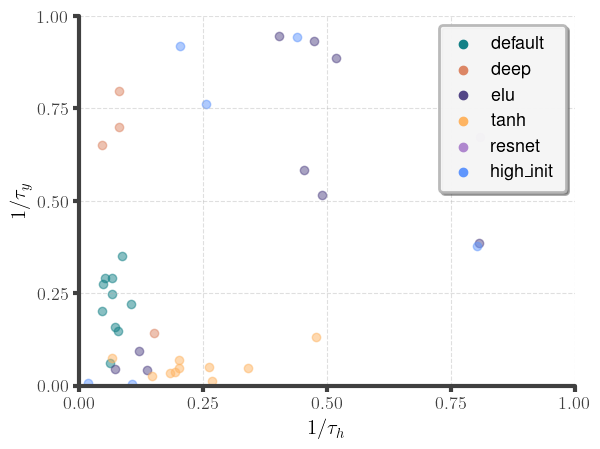

In [ ]:
for setting, tau in taus.items():
    plt.scatter(tau[0], tau[1], label=setting)
plt.xlabel(r"$1/\tau_h$")
plt.ylabel(r"$1/\tau_y$")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(0.5, -0.05))
pub_show()